In [1]:
import numpy as np
from skimage import graph
import matplotlib.pyplot as plt
import rasterio
import neilpy
import geopandas
import pandas as pd
from shapely.geometry import LineString
from scipy import stats
from pyproj import Transformer

In [2]:
src = rasterio.open('https://github.com/thomaspingel/geodata/raw/master/terrain/machu_picchu_area.tif')

Z = src.read(1).astype(np.float)
Z[Z==src.nodata] = np.nan
crs = src.crs
cellsize = np.mean(src.res)
Zt = rasterio.Affine(*src.get_transform())

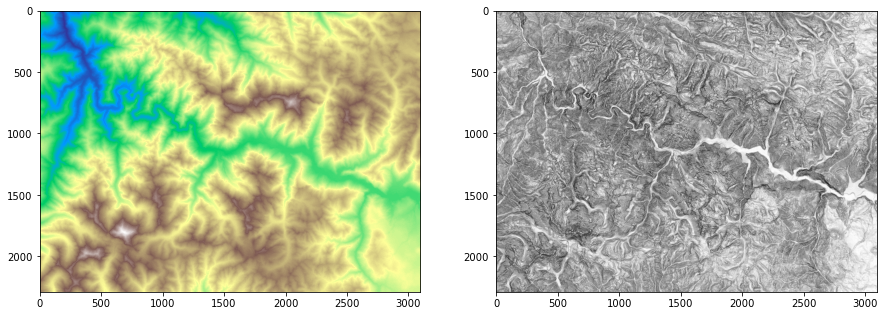

In [3]:
S = neilpy.slope(Z,cellsize,return_as='degrees')

# Show a hysometric tint and slope raster
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(Z,cmap='terrain')
plt.subplot(122)
plt.imshow(S,cmap='gray_r')
plt.show()

In [4]:
# https://www.gps-latitude-longitude.com/gps-coordinates-of-machu-picchu

start = (-72.263333, -13.258056)  # Ollantaytombo
end = ( -72.544963, -13.163141)   # Machu Piccu

# Transform to image CRS
start = neilpy.coord_transform(*start,4326,crs)
end = neilpy.coord_transform(*end,4326,crs)

In [5]:
inputs = {}
inputs['rademaker'] = neilpy.lcp_cost_rademaker(S)
inputs['tobler'] = neilpy.lcp_cost_tobler_hiking_function(S)
inputs['tobler_ve'] = neilpy.lcp_cost_tobler_hiking_function(neilpy.ve(S,ve=2.3))
inputs['pingel'] = neilpy.lcp_cost_pingel_exponential(S)

In [6]:
gdf = pd.DataFrame(columns=('name','geometry'))

routes = []

for key in inputs:
    print(key)
    route, cost = graph.route_through_array(inputs[key],src.index(*start),src.index(*end))
    route = np.array(route)
    routes.append(route)
    
    # Recover x,y coordinates
    x, y = src.transform *  np.fliplr(route).T
    
    # Create dictionary, create geometry
    d = {'name': key, 'geometry': LineString(zip(x,y))}
    
    gdf = gdf.append(d,ignore_index=True)
    
gdf = geopandas.GeoDataFrame(gdf,crs=crs,geometry='geometry')

rademaker
tobler
tobler_ve
pingel


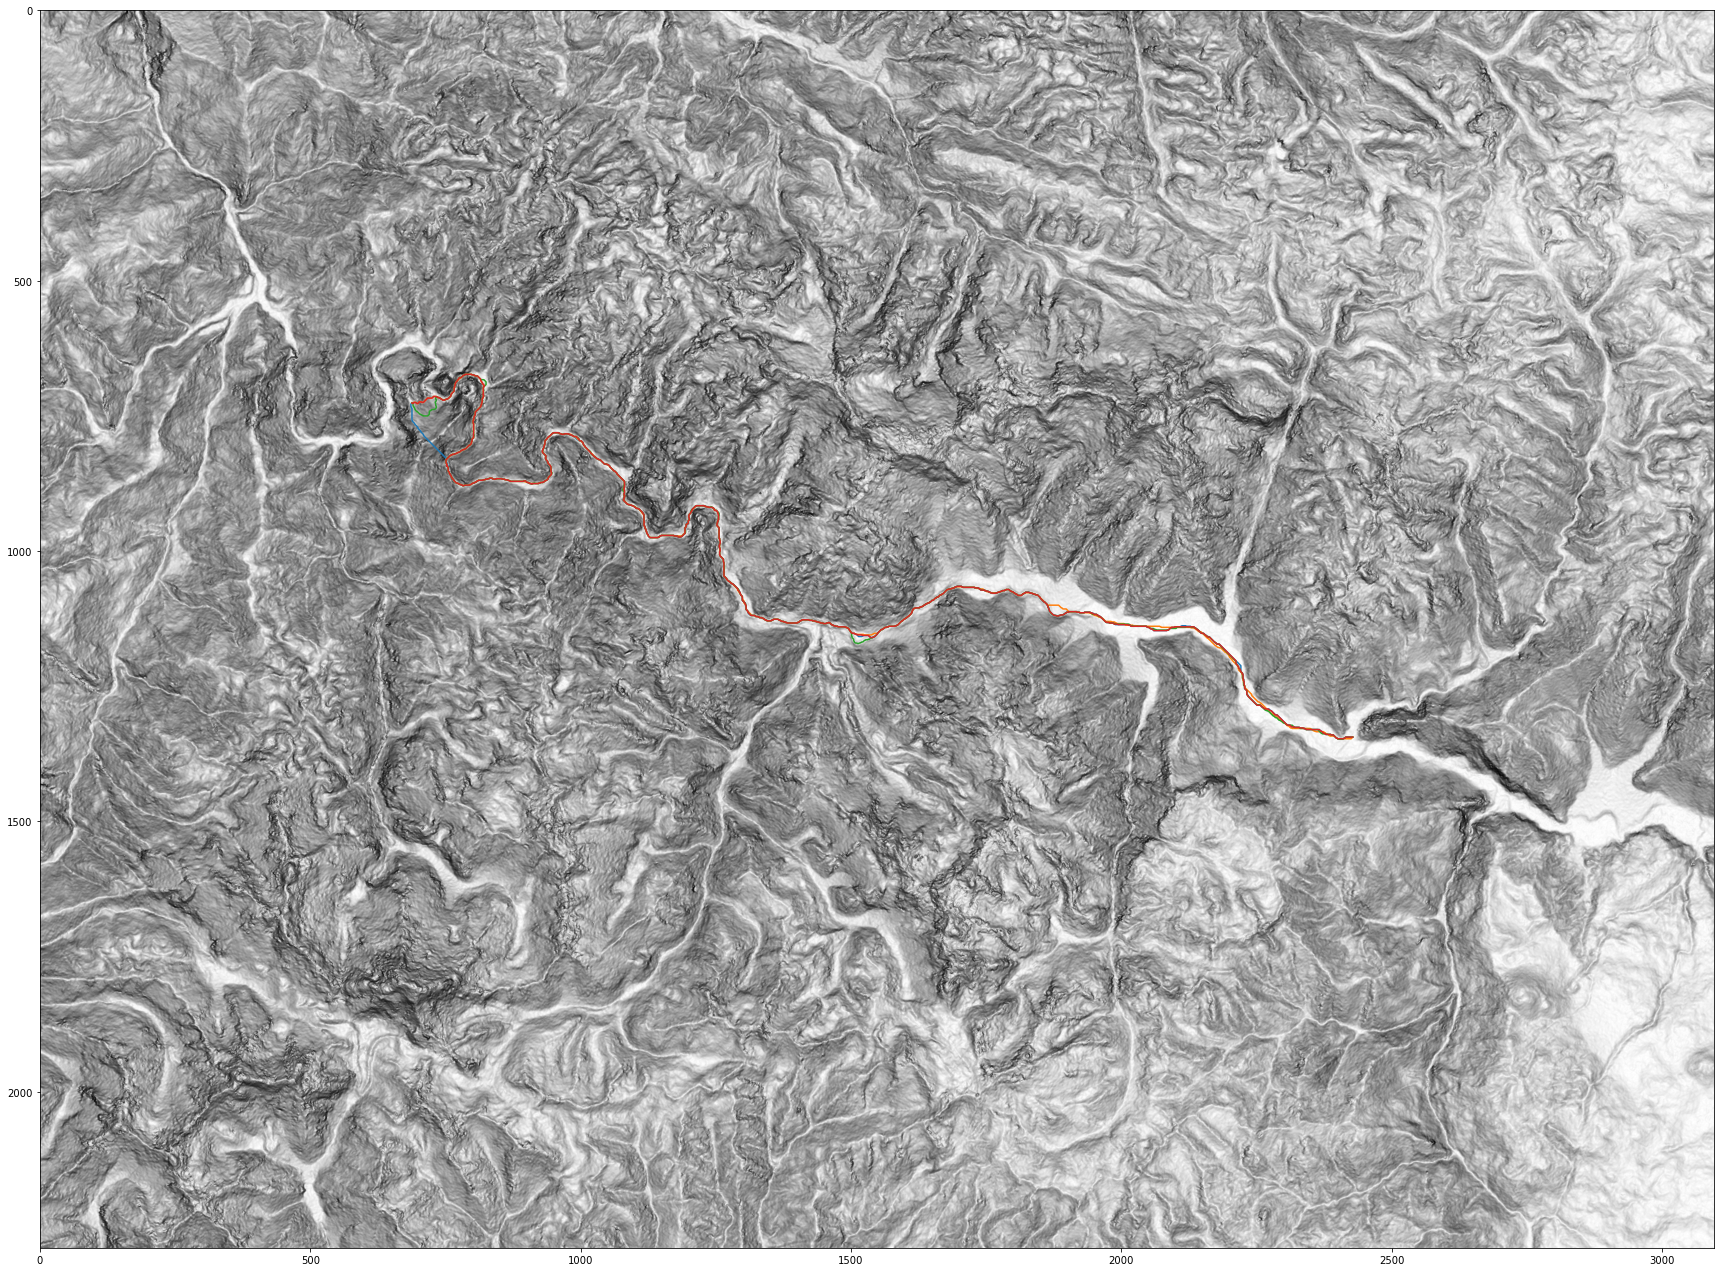

In [7]:
# Visualize results
plt.figure(figsize=(30,30))
plt.imshow(S,cmap='gray_r')
for route in routes:
    plt.plot(route[:,1],route[:,0])

In [8]:
# Write results

geopandas.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gdf.to_file('output.shp')
gdf.to_file('output.kml',driver='KML')